# Fine-Tuning of LLMs with Hugging Face

## Step 1: Installing and importing the libraries for Hugging Face

In [ ]:
!pip uninstall accelerate peft bitsandbytes transformers trl -y
!pip install accelerate peft==0.13.2 bitsandbytes transformers trl==0.12.0

Found existing installation: accelerate 1.5.2
Uninstalling accelerate-1.5.2:
  Successfully uninstalled accelerate-1.5.2
Found existing installation: peft 0.14.0
Uninstalling peft-0.14.0:
  Successfully uninstalled peft-0.14.0
Found existing installation: transformers 4.50.0
Uninstalling transformers-4.50.0:
  Successfully uninstalled transformers-4.50.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 126.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.4 MB/s eta 0:00:00
 

In [ ]:
!pip install huggingface_hub

In [ ]:
import os
import torch
from trl import SFTTrainer
from datasets import load_dataset
from peft import LoraConfig, PeftModel
from transformers import (AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, HfArgumentParser, TrainingArguments, pipeline, logging)

## Step 2: Setting up links to Hugging Face datasets and models

In [ ]:
model_identifier = "aboonaji/llama2finetune-v2"
source_dataset = "gamino/wiki_medical_terms"
formatted_dataset = "mlabonne/guanaco-llama2"

## Step 3: Setting up all the QLoRA hyperparameters for fine-tuning

In [ ]:
lora_hyper_r = 64
lora_hyper_alpha = 16
lora_hyper_dropout = 0.1

## Step 4: Setting up all the bitsandbytes hyperparameters for fine-tuning

In [ ]:
enable_4bit = True
compute_dtype_bnb ="float16"
quant_type_bnb = "nf4"
double_quant_flag = False

## Step 5: Setting up all the training arguments hyperparameters for fine-tuning

In [ ]:
#General Training Settings
results_dir = "./results"

#The directory where training results and checkpoints will be stored.

epochs_count = 10

#The number of training epochs.

enable_fp16 = False

#FP16 (Half-Precision) is disabled, meaning training will occur in full precision (FP32), which requires more memory.

enable_bf16 = False

#bfloat16 (BF16) is also disabled. BF16 can sometimes be more efficient than FP16 for training on NVIDIA Ampere GPUs and newer.

#Batch and Training Configuration
train_batch_size = 4

#The batch size used for training.

eval_batch_size = 4

#The batch size used for evaluation/validation.

accumulation_steps = 1

#Gradient accumulation steps allow training on larger batch sizes without increasing GPU memory usage.

#Optimization & Learning Rate Scheduling
optimizer_type = "paged_adamw_32bit"

#Uses Paged AdamW (32-bit), likely from bitsandbytes for efficient training.

train_learning_rate = 2e-4

#Learning rate of 0.0002, commonly used for fine-tuning transformer models.

decay_rate = 0.001

#Learning rate decay factor for gradual learning rate reduction.

scheduler_type = "cosine"

#Uses a cosine learning rate scheduler, which smoothly decreases the learning rate over time.
steps_limit=100

#Gradient and Stability Settings
grad_norm_limit = 0.3

#Gradient clipping to 0.3 to prevent exploding gradients.

warmup_percentage = 0.03

#3% of total training steps will be used for warm-up, gradually increasing the learning rate before normal training.
length_grouping=True
#Checkpointing & Logging
checkpointing_flag = True

#Enables saving model checkpoints.

checkpoint_interval = 0

#No periodic checkpoints (possibly meaning only final checkpoints are saved).

log_interval = 25

#Logs training progress every 25 iterations.

## Step 6: Setting up all the supervised fine-tuning arguments hyperparameters for fine-tuning

In [ ]:
enable_packing = False

#Packing is disabled, meaning each sequence is treated independently.

#When enable_packing = True, multiple short sequences can be combined into a single batch to utilize GPU memory more efficiently.

#If your dataset has many short sequences, enabling packing can improve efficiency.

sequence_length_max = None

#There is no explicit max sequence length restriction.

#If left as None, the model may default to its inherent maximum context window.

#Setting a specific length (e.g., sequence_length_max = 1024) can ensure consistent token processing and prevent excessive memory usage.

device_assignment = {"": 0}

#Likely indicates that the model is assigned to GPU 0.

#If using multiple GPUs, this assignment can be adjusted ({"": 0, "": 1, "": 2} etc.).

## Step 7: Loading the dataset

In [ ]:
training_data = load_dataset(formatted_dataset, split ="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/816 [00:00<?, ?B/s]

(…)-00000-of-00001-0e1c2f1cce3a255b.parquet:   0%|          | 0.00/8.99M [00:00<?, ?B/s]

(…)-00000-of-00001-f1915360acfe3aff.parquet:   0%|          | 0.00/476k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9846 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/518 [00:00<?, ? examples/s]

In [ ]:
training_data

Dataset({
    features: ['text'],
    num_rows: 9846
})

## Step 8: Defining the QLoRA configuration

Dynamically retrieves the data type from torch (e.g., torch.float16) based on the compute_dtype_bnb variable.

This ensures flexibility, allowing you to switch between different computation types (e.g., torch.float16, torch.bfloat16).

In [ ]:
dtype_computation = getattr(torch, compute_dtype_bnb)
bnb_setup = BitsAndBytesConfig(load_in_4bit=enable_4bit,  # Enables 4-bit quantization
                               bnb_4bit_quant_type=quant_type_bnb, # Sets quantization type (e.g., "nf4" for NormalFloat4)
                               bnb_4bit_use_double_quant=double_quant_flag, # Enables Double Quantization (reduces memory)
                               bnb_4bit_compute_dtype=dtype_computation)   # Uses the defined computation dtype (e.g., float16)


**Understanding Each Parameter**
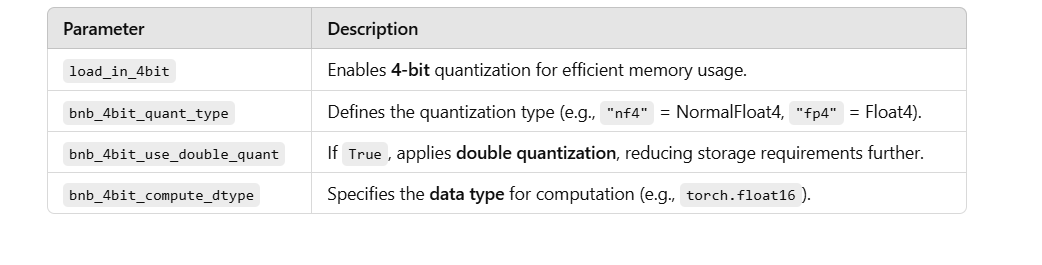

**When to Use This Configuration**

✅ If your goal is to fine-tune or infer large models efficiently, using 4-bit quantization saves memory while maintaining performance.

✅ "nf4" (NormalFloat4) is recommended for stability and performance in low-bit inference.

✅ Double Quantization (bnb_4bit_use_double_quant=True) further reduces memory but may slightly impact performance.

## Step 9: Loading the pre-trained LLaMA 2 model

This snippet is loading a LLaMA model with 4-bit quantization and specific configurations. Let’s analyze each line in detail:

AutoModelForCausalLM.from_pretrained(...) → Loads a pre-trained **causal language model (like LLaMA)** from a specified identifier (model_identifier).

quantization_config=bnb_setup → **Uses 4-bit quantization** (configured using BitsAndBytesConfig) to reduce memory usage.

device_map=device_assignment → Assigns the model to **specific GPUs** or CPUs for optimized execution.

**llama_model.config.use_cache = False**

Disables caching for key-value pairs during decoding.

Why? This is useful during fine-tuning because cached activations aren’t needed for gradient updates.

Should I set it to True?

✅ Fine-tuning → Keep it False.

✅ Inference → Set it to True (improves speed).

**llama_model.config.pretraining_tp = 1**

Controls tensor parallelism (TP) during training.

Setting it to 1 means no tensor parallelism, making it compatible with most training setups.

If using multiple GPUs with tensor parallelism, you might need to adjust this

Optimization Tips
✅ If running inference, enable caching:

**llama_model.config.use_cache = True**

✅ For multi-GPU training, configure tensor parallelism properly:

**llama_model.config.pretraining_tp = num_gpus**  # Example: num_gpus = 2 for dual-GPU

✅ Ensure **device_map=device_assignment** is correctly set for distributed execution:

**"auto"** → Automatically assigns GPUs.

**{"": 0}** → Puts everything on GPU 0.

**{0: "cuda:0", 1: "cuda:1"}** → Distributes across multiple GPUs.


Final Thoughts
This is a great setup for fine-tuning a LLaMA model using 4-bit quantization.

In [ ]:
llama_model = AutoModelForCausalLM.from_pretrained(model_identifier, quantization_config=bnb_setup, device_map=device_assignment)
llama_model.config.use_cache = False
llama_model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

## Step 10: Loading the pre-trained tokenizer for the LLaMA 2 model

In [ ]:
llama_tockenizer = AutoTokenizer.from_pretrained(model_identifier, trust_remote_code = True)
llama_tockenizer.pad_token=llama_tockenizer.eos_token
llama_tockenizer.padding_side = "right"


tokenizer_config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

## Step 11: Setting up the configuration for the LoRA fine-tuning method

In [ ]:
peft_setup = LoraConfig(
    lora_alpha=lora_hyper_alpha,
    lora_dropout=lora_hyper_dropout,
    r=lora_hyper_r,
    bias="none",
    task_type="CAUSAL_LM",
)


## Step 12: Creating a training configuration by setting the training parameters

In [ ]:
train_args=TrainingArguments(output_dir=results_dir, num_train_epochs=epochs_count,
                             per_device_train_batch_size=train_batch_size, per_device_eval_batch_size=eval_batch_size,
                             gradient_accumulation_steps=accumulation_steps,learning_rate=train_learning_rate,
                             weight_decay=decay_rate, optim=optimizer_type,save_steps=checkpoint_interval,logging_steps=1,
                             fp16=enable_fp16, bf16=enable_bf16,max_grad_norm=grad_norm_limit, max_steps=steps_limit,
                             warmup_ratio=warmup_percentage, group_by_length=length_grouping,lr_scheduler_type=scheduler_type,
                             gradient_checkpointing=checkpointing_flag)



## Step 13: Creating the Supervised Fine-Tuning Trainer

In [ ]:
llama_sft_trainer = SFTTrainer(model=llama_model,
                               args =train_args ,
                               train_dataset=training_data,
                               tokenizer=llama_tockenizer,
                               peft_config=peft_setup, dataset_text_field="text",
                               max_seq_length=sequence_length_max,packing=enable_packing)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:328: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/9846 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## Step 14: Training the model

In [ ]:
llama_sft_trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: duncan-ngacha (duncan-ngacha-self) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
1,1.266100
2,1.470700
3,1.631800
4,1.291500
5,1.471100
6,1.615100
7,1.554900
8,1.846200
9,1.971600
10,1.472600


TrainOutput(global_step=100, training_loss=1.4081252044439316, metrics={'train_runtime': 474.3331, 'train_samples_per_second': 0.843, 'train_steps_per_second': 0.211, 'total_flos': 6543090901549056.0, 'train_loss': 1.4081252044439316, 'epoch': 0.04061738424045491})

## Step 15: Chatting with the model

In [ ]:
user_prompt = "Propose a cleaning plan for a 3-room apartment shared by two people. Tasks should be split fairly and rotate every once in a while. The plan should be enough to keep the apartment more or less clean, while not being too demanding, The plan is structured into two tiers: weekly and monthly tasks."
test_generation_pipe = pipeline(task="text-generation", model=llama_model, tokenizer=llama_tockenizer, max_length=300,min_length=50,temperature=0.4,top_k=20,  top_p=0.5 )
generation_result = test_generation_pipe(f"<s>[INST]{user_prompt}[/INST]")
print(generation_result[0]['generated_text'])

Device set to use cuda:0


<s>[INST]Propose a cleaning plan for a 3-room apartment shared by two people. Tasks should be split fairly and rotate every once in a while. The plan should be enough to keep the apartment more or less clean, while not being too demanding, The plan is structured into two tiers: weekly and monthly tasks.[/INST]Here is a cleaning plan for a 3-room apartment shared by two people:

Weekly tasks:

* Wipe down the kitchen counters and sink after each meal
* Wipe down the bathroom sink and toilet after each use
* Vacuum the living room and bedrooms
* Dust the furniture and knick-knacks
* Clean the bathroom mirror and sink

Monthly tasks:

* Clean the refrigerator and stove
* Clean the bathroom shower and bathtub
* Clean the windows
* Clean the blinds
* Clean the baseboards

To split the tasks fairly, you can take turns doing each task every week. For example, one person can do the weekly tasks one week, and the other person can do them the next week. You can also alternate the monthly tasks, 